# AIRS Water Vapor

Read from retrievals and processed for comparison with CESM1-LE

### Do imports

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, gridspec, ccrs, 
    Iterable, cmaps, glob
    )

from functions import (
    masked_average, add_weights, leap_year,
    to_png, stats, MidpointNormalize, fix_cesm_time
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/'

In [3]:
airs_files = glob.glob('%s/*.nc4' % airs_dir)
airs_files.sort()

### Add time coordinate to AIRS L3 files so that I can open later efficiently with open_mfdataset

In [39]:
months_since = 0 # I will modify the time units instead and decoding should fix everything.

for i,_filename in enumerate(airs_files):
    
    year,month = _filename.split('.')[2:4]
    
    _temp_file = xr.open_dataset(_filename)
    
    # Add time dimension for concatenation
    _newfile = _temp_file.assign_coords({'time':months_since}).expand_dims('time')
    _newfile['time'].attrs['calendar'] = '360_day'
    _newfile['time'].attrs['units'] = "months since %s-%s-01" % (year,month)

    _newfile = xr.decode_cf(_newfile)
    
    new_lon = _newfile.Longitude.astype('float') % 360
    new_lat = _newfile.Latitude.astype('float') - 0.5 # place in gridcell centers
    _newfile = _newfile.assign_coords(Longitude=new_lon,Latitude=new_lat).sortby('Longitude')
    _newfile = _newfile.rename({'Longitude':'lon','Latitude':'lat'})
    
    dest_path = '%s/time_added/%s' % (airs_dir,_filename.split('/')[-1])
    print(dest_path)
    
    _newfile.to_netcdf(dest_path)    
    _newfile.close()
    
#     break
#     if i > 10: break # cutoff for testing

/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2002.09.01.L3.RetStd_IR030.v7.0.3.0.G20175163230.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2002.10.01.L3.RetStd_IR031.v7.0.3.0.G20218134003.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2002.11.01.L3.RetStd_IR030.v7.0.3.0.G20218133642.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2002.12.01.L3.RetStd_IR031.v7.0.3.0.G20218133629.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2003.01.01.L3.RetStd_IR031.v7.0.3.0.G20217173932.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2003.02.01.L3.RetStd_IR028.v7.0.3.0.G20217173600.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2003.03.01.L3.RetStd_IR031.v7.0.3.0.G20217173747.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/AIRS.2003.04.01.L3.RetStd_IR030.v7.0.3.0.G20174141813.hdf.nc4
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/

In [4]:
test_files = glob.glob('/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0//time_added/*')

In [5]:
bigest = xr.open_mfdataset(test_files,chunks={'lon':360,'lat':360,'time':220})

In [10]:
unchunked = bigest['SurfAirTemp_A'].chunk({'time':220,'lat':360,'lon':360})

In [16]:
unchunked.to_netcdf(_newfile_path)

In [14]:
tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

_newfile_path = '%s/AIRS.%s.200209-202012.L3.RetStd.v7.nc' % (tseries_dir,'SurfAirTemp_A')

In [15]:
_newfile_path

'/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.SurfAirTemp_A.200209-202012.L3.RetStd.v7.nc'

### Create timeseries for easier processing later

In [18]:
tseries_dir = '/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries/'

for _var in bigest.data_vars:
    
    _newfile_path = '%s/AIRS.%s.200209-202012.L3.RetStd.v7.nc' % (tseries_dir,_var)
    
    print(_newfile_path)
    
    _unchunked = bigest[_var].chunk({'time':220,'lat':360,'lon':360}) # unchunk so that it will write faster
    
    _unchunked.to_netcdf(_newfile_path)
    
#     break

/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.SurfAirTemp_A.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.SurfAirTemp_A_ct.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.SurfAirTemp_A_sdev.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.TotH2OVap_A.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.TotH2OVap_A_ct.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.TotH2OVap_A_sdev.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.H2O_MMR_A.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.H2O_MMR_A_ct.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.H2O_MMR_A_sdev.200209-202012.L3.RetStd.v7.nc
/glade/work/jonahshaw/obs/AIRS/AIRS3STM_7.0/tseries//AIRS.OLR_A.200209-20201

#### Old testing stuff

In [7]:
monthly_test = bigest['SurfAirTemp_A'].groupby('time.month').mean('time')

In [12]:
avg_test = monthly_test.mean('lon').sel(lat=slice(90,60))

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


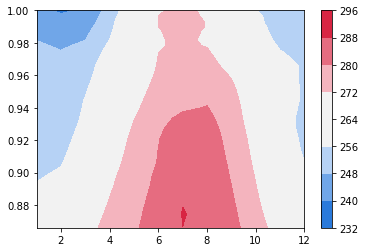

In [16]:
lat_weighted0 = np.sin(np.pi/180*avg_test['lat'])
palette = sns.diverging_palette(257, 10, s=99, l=44, sep=50, n=8, as_cmap=True)

im0 = plt.contourf(avg_test['month'],lat_weighted0,avg_test.transpose('lat','month'), # -1.4,0.4
                       cmap=palette)#,norm=mpl.colors.TwoSlopeNorm(vmin=-0.9, vcenter=0., vmax=0.9),levels=np.arange(-0.9,0.11,0.2),extend='both')

plt.colorbar(im0)